In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import scipy.sparse as sparse
from test import *

from itertools import chain
from pathlib import *
from math import ceil
from sqlalchemy import create_engine
from pandarallel import pandarallel

from test import *
from helper import *
from tree_weight import *
from time import time
from main import make_graph_from_tree
from multiprocessing import *

from typing import List
%matplotlib inline

In [2]:
pandarallel.initialize(nb_workers=cpu_count() - 1)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
image_folder = 'graphs/'
tree = 'benchmark_models/sugiyama/trees/g3_7_7_7.sqlite'
info_df = to_df(tree, 'info').set_index('NodeID')
nodes_df = to_df(tree, 'nodes').set_index('NodeID')
valid_df = nodes_df[nodes_df['Status'] != 3]

print(nodes_df.shape)

(81515, 11)


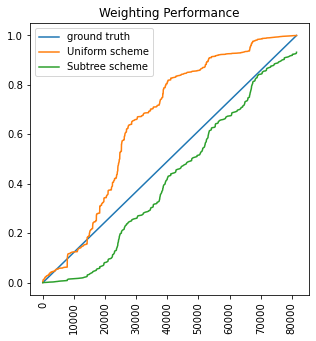

In [4]:
dfs_ordering = nodes_df[nodes_df['Status'] != 3].sort_values('DFSOrdering').reset_index()['NodeID'].to_numpy()
cum_sums = {
    'Uniform': get_cum_weight(nodes_df, 'UniformNodeWeight', dfs_ordering),
    'Subtree': get_cum_weight(nodes_df, 'SearchSpaceNodeWeight', dfs_ordering),
#     'True': get_cum_weight(nodes_df, 'TrueNodeWeight', dfs_ordering)
}

plot_goodness(cum_sums)
plt.show()

# NOTE:
DES without adaptive resolution falls apart in sudden upwards trajectory of cumulative weight, which is the very thing we had wanted DES to accomodate too. Thus, it may be better to update with larger distance

In [13]:
def get_time_series_step_left(goal, current, slope):
    """Return number of time series steps left before completion"""
    return (goal - current) / slope

def get_absolute_steps_size(steps, res):
    """Given a number of time series steps left before completion and the current resolution, output the absolute value of steps left"""
    # based on this paper http://www.optimization-online.org/DB_HTML/2020/04/7722.html
    return (2 ** res) * h

cum_sums_leaves = cum_sums['Uniform'].\
                    loc[nodes_df[nodes_df['Status'].isin({0, 1})]\
                    ['DFSOrdering']].sort_values() # filtered out non-leaves

# parameters
a = 0.01
b = 0.001

init_q = cum_sums_leaves.iloc[0] # such that the first iteration brings q and s into here
init_s = 0
q_list = []
s_list = []
completion = pd.DataFrame({'dfs_order': [], 'completion': []})


every = 1 # resolution
step = 0
i = 0
while i < len(cum_sums_leaves.index):
    
    if len(q_list) == 1024:
        # trigger squeeze and recomputation
        every *= 2 # double the resolution
        print("resolution: ", every)
        # reset seen q and s values
        q_list = []
        s_list = []
        # recompute with the new resolution , 0, every, 2*every, ... i (not including i, as that will be handled by the lower loop)
        for j in range(0, i, every):
            if len(q_list) > 0:
                q_prev, s_prev = q_list[-1], s_list[-1]
            else:
                q_prev, s_prev = init_q, init_s
            q = a * cum_sums_leaves.iloc[j] + (1 - a) * (q_prev + s_prev)
            s = b * (q - q_prev) + (1 - b) * s_prev
            q_list.append(q)
            s_list.append(s)
   
    if len(q_list) > 0:
        q_prev, s_prev = q_list[-1], s_list[-1]
    else:
        q_prev, s_prev = init_q, init_s        
    q = a * cum_sums_leaves.iloc[i] + (1 - a) * (q_prev + s_prev)
    s = b * (q - q_prev) + (1 - b) * s_prev
    q_list.append(q)
    s_list.append(s)
        
    if s > 0:
        hasLeft = every * (1 - q) / s # number of leaves nodes left
        soFar = cum_sums_leaves.index[i]
        total = 2 * (i + hasLeft) - 1 # number of total nodes left
        completion = completion.append({'dfs_order': soFar, 'completion': soFar / total}, ignore_index=True)
    else:
        completion = completion.append({'dfs_order': cum_sums_leaves.index[i], 'completion': q}, ignore_index=True) # stalled, just report the raw q value
        
    i += every
    step += 1
    
# NOTE: completion index is the dfs ordering, not the actual nodeid
# print(q_list)

resolution:  2
resolution:  4
resolution:  8
resolution:  16
resolution:  32
resolution:  64


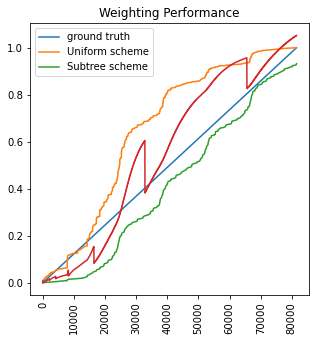

In [15]:
empty_df = pd.DataFrame({
    'dfs_order': list(set(nodes_df[nodes_df['Status'] != 3].index) - set(completion['dfs_order'])),
    'completion': np.nan
})
# completion = pd.DataFrame.concat([completion, pd.DataFrame({'index': list(set(range()))})])
x = pd.concat([completion, empty_df]).sort_values('dfs_order').fillna(method='ffill').fillna(0).set_index('dfs_order')
plot_goodness(cum_sums)
plt.plot(x.index, x.completion)

In [1]:
import yaml

In [4]:
f = open('./settings.yaml', 'r')
data = yaml.safe_load(f)
f.close()

In [8]:
data['exponential_smoothing']['uniform_scheme']

{'a': 0.001, 'b': 0.001}